### brain inspired modular training
adapted from Ziming Liu, Eric Gan, Max Tegmark


In [1]:
''' load libraries, nothing fancy here '''
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
from typing import Union, Callable

### Contents
1) The model running on a toy dataset and the outputs
2) A deeper dive into the functions, with as many figures and text as needed to explain how it works

### Part 1) The model applied to a toy dataset

***
#### Sample generator


In [2]:

def gen_samples(n_samples):
    ''' some simple dataset '''
    a = np.random.normal(0,1,size=(n_samples,4))
    return (a, np.array([a[:,0]*a[:,3] + a[:,1]*a[:,2],
                         a[:,0]*a[:,3] - a[:,1]*a[:,2]]).T)

def batchify(data, targets, batch_size, validation_split = 0.01):
    '''
    Input:  (number of samples, (data shape)) format.
    Output: (n batches, batch size, (data_shape))
    '''

    data_shape = data.shape[1:]
    targets_shape = targets.shape[1:]
    # 
    cutoff = int((len(data)*(1-validation_split))//batch_size * batch_size)
    val_cutoff = len(data)-cutoff # how many validation sample we have
    
    val_data_list = list()
    val_target_list = list()
    
    val_batches = int(val_cutoff//batch_size * batch_size)
    if val_cutoff//batch_size != 0:
        for i in range((val_cutoff//batch_size)-1): # the "-1" leaves the last batch to be manually added in cleanup
            val_data_list.append(tf.cast(data[cutoff + i * batch_size : cutoff + (i+1) * batch_size].reshape((batch_size,) + data_shape),dtype=tf.float32))
            val_target_list.append(tf.cast(targets[cutoff + i * batch_size : cutoff + (i+1) * batch_size].reshape((batch_size,) + targets_shape),dtype=tf.float32))
    else: i = 0 # if validation set fits entirely within a batch, need to initialize i
    # manually append last bit
    val_data_list.append(tf.cast(data[cutoff + (i+1) * batch_size : cutoff + (i+2) * batch_size + batch_size].reshape((-1,) + data_shape), dtype=tf.float32))
    val_target_list.append(tf.cast(targets[cutoff + (i+1) * batch_size : cutoff + (i+2) * batch_size + batch_size].reshape((-1,) + targets_shape),dtype=tf.float32))
    
    train_data = data[:cutoff].reshape((-1, batch_size) + data_shape)
    train_targets = targets[:cutoff].reshape((-1, batch_size) + targets_shape)

    if validation_split != 0: # not quite right still
        print('testing validation split')
        print(len(val_data_list))
        assert val_data_list[0].shape[0] != 0, 'validation split insufficient'
    return (train_data, train_targets), (val_data_list, val_target_list)

(train_data_in, train_data_out), (train_data_in_val, train_data_out_val) = batchify(*gen_samples(30000),
                                                                                    batch_size = 64, validation_split = 0.05)

print(f'{train_data_in.shape = }')
print(f'{len(train_data_in_val) = }')

testing validation split
23
train_data_in.shape = (445, 64, 4)
len(train_data_in_val) = 23


#### BIMT Model

In [3]:

class BIMT_model:
    def __init__(self,
                 hidden_layer_sizes: list,
                 width: Union[list, float],
                 input_size: int,
                 output_size: int,
                 final_activation = tf.keras.activations.softmax,
                 standard_activation = tf.keras.activations.swish,
                 loss_function: Union[Callable, str]= 'mse',
                ):
        self.activations = [standard_activation] * (len(hidden_layer_sizes)) + [final_activation] # << this needs to be made dynamic
        self.input_size  = input_size
        self.output_size = output_size
        
        self.input_patch = tf.eye(input_size)   # patches allows swapping of non-hidden positions
        self.output_patch = tf.eye(output_size)
        
        self._layers = [input_size] + hidden_layer_sizes + [output_size]

        if type(width) == list: assert len(width) == len(hidden_layer_sizes)+2, 'since width is a list, must define each layer individually'
        else: width = [width] * (len(hidden_layer_sizes) + 2) # "+2" for input and output neurons
        self.embedding_widths = width # < this width ends up being a list

        self._build_model()    # makes weights and biases
        self._place_neurons()  # places neurons
        self._find_distances() # calculate distance matrixces of connections
        self.loss_log = {'main_loss':[], 'l1':[], 'spring':[], 'bias':[], 'total':[], 'val_main_loss':[]}
        
        if type(loss_function) != str: self.loss_function = loss_function
        elif loss_function == 'mse': self.loss_function = tf.keras.losses.mean_squared_error
        elif loss_function == 'bce': self.loss_function = tf.keras.losses.binary_crossentropy

    @property
    def trainable_weights(self):
        return [_params for _layer in self.model for _params in _layer]

    def _build_model(self):
        '''
        Internal Method
        Initialize the matrices for the dense connections
        Uses a random normal initializer for weight values
        '''
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        trainable_parameters = list()
        
        # hidden layers
        for idx, (former_layer, later_layer) in enumerate(zip(self._layers[:-1], self._layers[1:])):
            temp = [tf.Variable(initializer(shape=(former_layer, later_layer))), # weights
                    tf.Variable(initializer(shape=(later_layer,)))]              # biases
            trainable_parameters.append(temp)
        self.model = trainable_parameters
        
    def _dist(self, n1, n2):
        '''
        Internal Method
        Calculates distance between two neurons (2D only, for now)
        '''
        n1 = np.array(n1).T
        n2 = np.array(n2).T
        return np.sqrt( np.sum((n1-n2)**2))

    def _place_neurons(self):
        '''
        Internal Method
        Determines 2D coordinates of each neuron
        '''
        self.neuron_locations = list()
        for _layer_idx, (_width, _n_neurons)  in enumerate(zip(self.embedding_widths, self._layers)):
            temp_layer = []
            for _y_pos in np.linspace(-_width, _width, _n_neurons):
                temp_layer.append(np.array([_layer_idx, _y_pos]))
            self.neuron_locations.append(np.array(temp_layer))
            
    def _find_distances(self):
        '''
        Internal Method
        Precalculates distances between neurons
        '''
        self._distances = list()
        for _in_layer, _out_layer in zip(self.neuron_locations[:-1], self.neuron_locations[1:]):
            temp = np.zeros((len(_in_layer), len(_out_layer)))
            for idx0, _n0 in enumerate(_in_layer):
                for idx1, _n1 in enumerate(_out_layer):
                    temp[idx0, idx1] = self._dist(_n0, _n1)
            self._distances.append(tf.cast(temp, dtype=tf.float32))

    def predict(self, data):
        '''
        Apply the weights and biases to the input
        '''
        running_data = tf.matmul(data, self.input_patch) # apply input patch

        for _act, _layer in zip(self.activations, self.model): # apply all hidden layers
            running_data = _act(tf.add(tf.matmul(running_data, _layer[0]), _layer[1]))
            
        running_data = tf.matmul(running_data, self.output_patch) # apply output patch
        return running_data
    
    def train_step(self, batch_in, batch_out, l1_coeff, reg_coeff):
        '''
        This function will get tf.Graph optimized in the training loop
        '''
        temp_loss_log = {}
        with tf.GradientTape() as tape:
            # prediction cost
            pred_cost = tf.reduce_mean(self.loss_function(batch_out, self.predict(batch_in)))

            # l1 cost
            l1_cost = tf.reduce_sum(tf.math.abs(self.model[0][0]))
            for _weights in self.model[1:]: l1_cost += tf.reduce_sum(tf.math.abs(_weights[0]))

            # spring cost
            # (spring cost only calculates springiness to later layers, which is probably a sufficient approximation)
            spring_cost = tf.reduce_sum( tf.math.multiply( self._distances[0], tf.math.abs(self.model[0][0]) ) ) # spring is good for this first layer
            for (_weights, _distance) in zip(self.model[1:], self._distances[1:]): spring_cost += tf.reduce_sum( tf.math.multiply(_distance, tf.math.abs(_weights[0])) )

            # bias costs
            bias_cost = tf.reduce_sum(tf.math.abs(self.model[0][1]))
            for _bias in self.model[1:]: bias_cost += tf.reduce_sum(tf.math.abs(_weights[1]))

            total = pred_cost + l1_coeff * l1_cost + reg_coeff * (spring_cost + bias_cost)

            # log these loss components
            temp_loss_log['main_loss'] = tf.reduce_mean(pred_cost)
            temp_loss_log['l1']        = tf.reduce_mean(l1_cost) * l1_coeff
            temp_loss_log['spring']    = tf.reduce_mean(spring_cost) * reg_coeff
            temp_loss_log['bias']      = tf.reduce_mean(bias_cost) * reg_coeff
            temp_loss_log['total']     = tf.reduce_mean(total)

        grad = tape.gradient(total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grad, self.trainable_weights))
        return temp_loss_log
    
    def train(self,
              training_data_input,
              training_data_output,
              val_input,
              val_output,
              learning_rate = 1e-4,
              n_epochs = 10,
              top_k=5,
              l1_coeff = 1e-3,
              reg_coeff = 1e-3,
              ):
        '''
        Train the model given parameters, applies swapping at end of epoch
        '''

        training_data_input = tf.cast(training_data_input, dtype=tf.float32)
        training_data_output = tf.cast(training_data_output, dtype=tf.float32)
        
        for k in tqdm(range(n_epochs)):
            # reinitialize optimizer
            self.optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
            
            # create tf graph of train_step(). this allows the optimizer to be reinitialized
            # (otherwise it will throw an error due to variables being overwritten) and
            # major speed up. it also allows swapping (not sure how/why it was failing before).
            train_loop_fn = tf.function(self.train_step)
            
            # loop through training
            temp_losses = {'main_loss':[], 'l1':[], 'spring':[], 'bias':[], 'total':[], 'val_main_loss':[]}
            for batch_in, batch_out in zip(training_data_input, training_data_output):
                training_logs = train_loop_fn(batch_in, batch_out, l1_coeff, reg_coeff)
                for key in training_logs.keys():
                    temp_losses[key].append(training_logs[key])
                    
            # swap the top neurons
            self.perform_swap(top_k)
            
            for batch_in, batch_out in zip(val_input, val_output):
                val_loss = tf.reduce_mean(self.loss_function(batch_out, self.predict(batch_in)))
                temp_losses['val_main_loss'].append(val_loss)
            
            # append epoch-level losses
            for key in temp_losses.keys():
                self.loss_log[key].append(tf.reduce_mean(temp_losses[key]))


    def perform_swap(self, top_k = 5):
        '''
        Swaps neuron location to minimize spring loss
        '''
        # swap inputs
        self.input_patch, _, self.model[0][0] = self._swapping_neurons(incoming_weights = self.input_patch,
                                                                       incoming_distances = tf.ones(self.input_size), #placeholder, distances don't matter on this layer
                                                                       intermediate_biases = tf.zeros(self.input_size), # placeholder, no bias here
                                                                       outgoing_weights = self.model[0][0],
                                                                       outgoing_distances = self._distances[0],
                                                                       top_k = top_k)
        # swap hidden layers
        for idx, ((_weight0, _bias0), (_weight1, _unused), _d0, _d1) in enumerate(zip(self.model[:-1],
                                                                                      self.model[1:],
                                                                                      self._distances[:-1],
                                                                                      self._distances[1:])):

            self.model[idx][0], self.model[idx][1], self.model[idx+1][0] = self._swapping_neurons(incoming_weights = _weight0,
                                                                                                  incoming_distances = _d0,
                                                                                                  intermediate_biases = _bias0,
                                                                                                  outgoing_weights = _weight1,
                                                                                                  outgoing_distances = _d1,
                                                                                                  top_k = top_k)
        # swap outputs
        self.model[-1][0], self.model[-1][1], self.output_patch = self._swapping_neurons(incoming_weights = self.model[-1][0],
                                                                                         incoming_distances = self._distances[-1],
                                                                                         intermediate_biases = self.model[-1][1],
                                                                                         outgoing_weights = self.output_patch,
                                                                                         outgoing_distances = tf.ones(self.output_size),
                                                                                         top_k = top_k)

    def _create_swaps(self, neuron_index: int, dims: int):
        '''
        Internal Method
        returns permutations for new locations of the neurons
        '''
        z = np.arange(dims).reshape(-1,1).repeat(dims).reshape(dims,dims).T
        di = np.diag_indices(dims)
        z[:,neuron_index] = np.arange(dims) # replace column
        z[di] = neuron_index # replace diagonal with constant
        return z


    def _swapping_neurons(self,
                     incoming_weights,
                     incoming_distances,
                     intermediate_biases,
                     outgoing_weights, 
                     outgoing_distances,
                     top_k = 4):
        ''' 
        Internal Method
        Figures out which neurons to swap (most significant neurons), then calculates how to minimize it with a swap
        '''
        incoming_weights = incoming_weights.numpy()
        outgoing_weights = outgoing_weights.numpy()
        incoming_distances = incoming_distances.numpy()
        outgoing_distances = outgoing_distances.numpy()
        intermediate_biases = intermediate_biases.numpy()
        
        # Find indices of most significant neurons
        incoming_weights_copy = abs(incoming_weights).sum(axis=0) + abs(outgoing_weights).sum(axis=1)
        sorted_neurons = incoming_weights_copy.argsort()

        # for k most significant neurons, look at their swap potentials and greedily choose best
        for _sn in sorted_neurons[-top_k:][::-1]: # _sn for signficant neuron

            _temp_swaps = self._create_swaps(neuron_index = _sn,
                                              dims = len(sorted_neurons)) # creates every combination for the top selected neuron

            springs_test = np.zeros(len(sorted_neurons))
            for idx, _swap in enumerate(_temp_swaps):
                _incoming = (abs(incoming_weights).T[_swap].T * incoming_distances).sum()
                _outgoing = (abs(outgoing_weights)[_swap] * outgoing_distances).sum()
                springs_test[idx] = _incoming + _outgoing
            _best = springs_test.argmin()

            incoming_weights = incoming_weights.T[_temp_swaps[_best]].T
            intermediate_biases = intermediate_biases.T[_temp_swaps[_best]].T
            outgoing_weights = outgoing_weights[_temp_swaps[_best]]

        # remake into TF tensors
        incoming_weights = tf.Variable(incoming_weights)
        intermediate_biases = tf.Variable(intermediate_biases)
        outgoing_weights = tf.Variable(outgoing_weights)

        return incoming_weights, intermediate_biases, outgoing_weights

    def prune(self,threshold = 1e-1):
        '''
        Remove neurons that have no weights above the threshold.
        Run after training.
        '''
        running_neurons = list()
        running_neurons.append(self.input_size)
        
        for earlier_index, later_index in zip(np.arange(len(self.model)-1), np.arange(1, len(self.model))):
            mask1 = (tf.reduce_sum(abs(self.model[earlier_index][0]),axis=0) > threshold) # incoming weights
            mask2 = (tf.reduce_sum(abs(self.model[later_index][0]),  axis=1) > threshold) # outgoing weights
            mask = mask1 & mask2
            
            self.model[earlier_index][0] = tf.Variable(np.array(self.model[earlier_index][0])[:,mask]) # update weights
            self.model[earlier_index][1] = tf.Variable(np.array(self.model[earlier_index][1])[mask]) # update bias

            # apply mask to following layer
            self.model[later_index][0] = self.model[later_index][0][mask] # then it will get iterated on?
            running_neurons.append(np.array(mask).sum())
        running_neurons.append(self.output_size)
        
        self._layers = running_neurons
        self._place_neurons()

#### Train the BIMT model

In [4]:
# instantiate model
my_model_new = BIMT_model(input_size = 4,
                          output_size = 2,
                          hidden_layer_sizes = [18,16],
                          final_activation = tf.keras.activations.linear,
                          width = 3,
                          loss_function = 'mse'
                         )


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [5]:

my_model_new.train(n_epochs = 25,
                   training_data_input = train_data_in,
                   training_data_output = train_data_out,
                   val_input = train_data_in_val,
                   val_output = train_data_out_val,
                   learning_rate = 1e-2)


100%|███████████████████████████████████████████| 25/25 [01:17<00:00,  3.11s/it]


#### Plotting

In [7]:
class plotting_module:
    ''' 
    This is a module that contains the plotting elements of the BIMT model.
    It's kept as a separate subclass for readability since these are 
    important for evaluation, but not for training
    '''
    def __init__(self, bimt_model):
        self.bimt_model = bimt_model
        
    def plot_lr_curves(self):
        assert hasattr(self.bimt_model, 'loss_log'), 'train model first'
        fig,ax = plt.subplots(1, len(self.bimt_model.loss_log.keys())-1, figsize=(18,4))

        for idx, _l in enumerate(self.bimt_model.loss_log.keys()):
            if _l == 'val_main_loss': idx = 0 # place validation of main loss on same figure
            ax[idx].plot(self.bimt_model.loss_log[_l], label=_l)
            ax[idx].set_xlabel('epoch')
            ax[idx].set_ylabel('loss')

        for idx in range(len(self.bimt_model.loss_log.keys())-1): ax[idx].grid(); ax[idx].legend();
        plt.tight_layout()
        ax[0].set_yscale('log')
        plt.show()

    def plot_weights(self, threshold = 0.05):
        def _create_norm(data):
            data = np.array(data)
            extreme = max(abs(data.min()), abs(data.max()))
            norm = mpl.colors.TwoSlopeNorm(vmin=-extreme, vcenter=0, vmax=extreme)
            return norm

        fig,ax = plt.subplots(1,len(self.bimt_model.model)+2,figsize=(14,4))

        panel = ax[0].imshow(self.bimt_model.input_patch, cmap='plasma')
        ax[0].set_title('input patch')
        plt.colorbar(panel, ax=ax[0])
        
        for i, (w,b) in enumerate(self.bimt_model.model):
            panel = ax[i+1].imshow(w, norm=_create_norm(w), cmap='seismic') # "+1" to offset from the input patch
            ax[i+1].set_title(f'layer {i} weights')
            plt.colorbar(panel, ax=ax[i+1])

        panel = ax[-1].imshow(self.bimt_model.output_patch, cmap='plasma')
        ax[-1].set_title('output patch')
        plt.colorbar(panel, ax=ax[-1])
        plt.tight_layout()
        plt.show()
        
    def plot_connections(self,
                         input_names: list = None, # feature names
                         output_names: list = None, # targets
                         edge_threshold = 1e-1):
        
        # make labels for features
        if input_names == None: input_names = [f'x{i}' for i in range(self.bimt_model.input_size)]
        if output_names == None: output_names = [f'y{i}' for i in range(self.bimt_model.output_size)] 
        
        # plot neuron locations
        for i in self.bimt_model.neuron_locations:
            plt.scatter(*i.T)

        # plot edges
        for _prev_idx, _later_idx in zip(np.arange(len(self.bimt_model.model)), np.arange(1,len(self.bimt_model.model)+1)):

            for _idx1, _pos1 in enumerate(self.bimt_model.neuron_locations[_prev_idx]):
                for _idx2, _pos2 in enumerate(self.bimt_model.neuron_locations[_later_idx]):
                    _weight = self.bimt_model.model[_prev_idx][0][_idx1][_idx2]
                    if tf.abs(_weight) > edge_threshold: # technically not required, but way faster if not plotting everything
                        if _weight > 0: color='r'
                        else: color='b'
                        plt.plot([_pos1[0],_pos2[0]],
                                 [_pos1[1],_pos2[1]],
                                 ls='--',linewidth=tf.abs(_weight),c=color)

        # feature names
        sorted_intput_args = np.array(input_names)[np.argmax(self.bimt_model.input_patch,axis=0)]
        for _argument, _pos in zip(sorted_intput_args,
                                   self.bimt_model.neuron_locations[0]):
            plt.text(*_pos, _argument)

        sorted_output_args = np.array(output_names)[np.argmax(self.bimt_model.output_patch,axis=0)]
        for _argument, _pos in zip(sorted_output_args,
                                   self.bimt_model.neuron_locations[-1]):
            plt.text(*_pos, _argument)
        plt.xlabel('neuron layer')
        plt.xticks(np.arange(len(self.bimt_model._layers)),
                   ['input'] + list(np.arange(len(self.bimt_model._layers)-2)) + ['output'])
        plt.show()
        
    def vis_evaluate(self, test_input, test_output):
        assert test_output.shape[1] == 2, 'this visual evaluation only work on 2D outputs'
        
        test_input = tf.cast(test_input, dtype=tf.float32)
        pred_values = self.bimt_model.predict(test_input)
        
        plt.figure()
        plt.scatter(test_output[:,0], test_output[:,1],label='real')
        plt.scatter(pred_values[:,0], pred_values[:,1],label='pred')
        plt.grid(); plt.legend(); plt.xlabel('output[0]'); plt.ylabel('output[1]')
        plt.show()

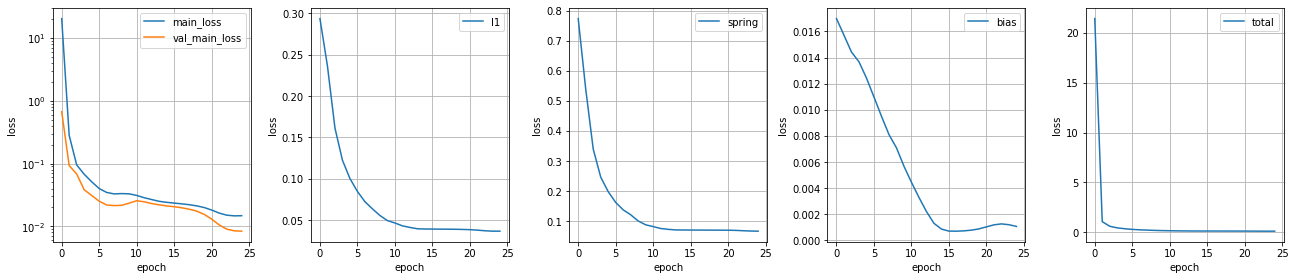

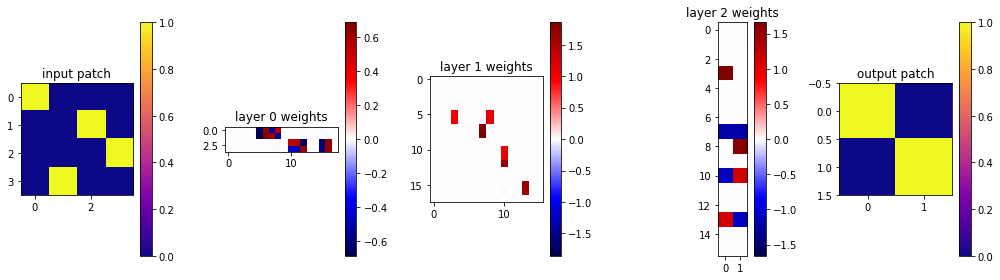

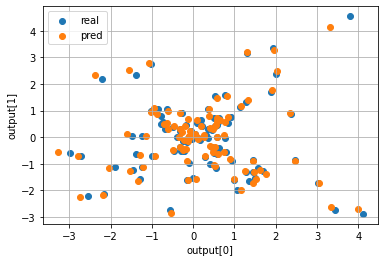

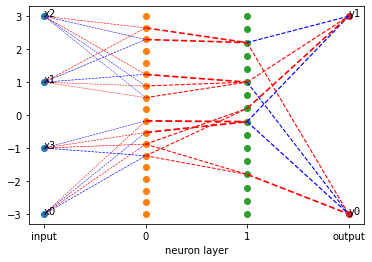

In [9]:
''' plot losses '''
my_plotting_module = plotting_module(bimt_model = my_model_new)

my_plotting_module.plot_lr_curves()
my_plotting_module.plot_weights(threshold=0.05)

i,o = gen_samples(100)
i = tf.cast(i, dtype=tf.float32)
my_plotting_module.vis_evaluate(i,o)
my_plotting_module.plot_connections()


***
### Part 2: Explanation

What did we just do?
What is swapping?

Below we go into detail about how this is implemented.

***
These layers are fully connected so they can be represented as a matrix and bias.
To apply the layer is to perform a matrix multiplication, apply the bias, then the activation function.

Therefore the weights and biases are initialized using tf.Variable(), which can be trained. For simplicity, the demonstration below will only focus on the weights.

Swapping a neuron is simply changing the row of the first weight matrix and the column of the second (and swapping the position of the bias).
It is computationally expensive to try all permutations of neurons, so the top *k* neurons are selected.
These are identified as the neurons with the highest absolute connected weights.

The "spring cost" is calculated by weight * distance of each neuron, and is the focus of the work below.

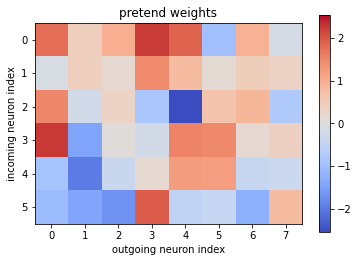

In [10]:
''' example of weights '''

def create_norm(data):
    data = np.array(data)
    extreme = max(abs(data.min()), abs(data.max()))
    norm = mpl.colors.TwoSlopeNorm(vmin=-extreme, vcenter=0, vmax=extreme)
    return norm

np.random.seed(0)
pretend_weights = np.random.normal(size=(6,8))

plt.imshow(pretend_weights, cmap='coolwarm', norm=create_norm(pretend_weights))
plt.colorbar(); plt.ylabel('incoming neuron index'); plt.xlabel('outgoing neuron index'); plt.title('pretend weights');

most_significant_neuron = 4


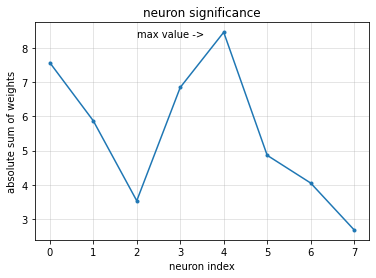

In [11]:
''' which neuron is the most significant (as determined by sum of connected weights) '''
neuron_signficances = abs(pretend_weights).sum(axis=0)

plt.plot(neuron_signficances,marker='.')
plt.grid(alpha=0.4)
plt.ylabel('absolute sum of weights')
plt.xlabel('neuron index')
plt.text(2,8.3,'max value ->'), plt.title('neuron significance');

most_significant_neuron = neuron_signficances.argmax()
print(f'{most_significant_neuron = }')

***
Now that we have the most significant neuron, we will try swapping it to other locations.

A "swap" can be represented as a list of integers indicating the new position of the neuron.

The way we check whether a swap is better or worse is by applying the swap and measuring the new spring cost.

Below we look at the set of swaps for this weight shape.

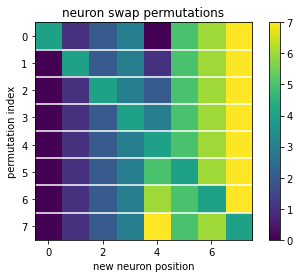

In [12]:
''' every permutation of moving the most significant neuron '''
temp_swaps = my_model_new._create_swaps(neuron_index = most_significant_neuron,
                                        dims = pretend_weights.shape[1])

plt.imshow(temp_swaps); plt.colorbar(); plt.ylabel('permutation index'); plt.xlabel('new neuron position'); plt.title('neuron swap permutations')
for i in np.arange(pretend_weights.shape[1]-1): plt.axhline(i+0.5, c='w')


In [13]:
''' initialize a demo BIMT to get distances '''
demo_BIMT = BIMT_model(hidden_layer_sizes=[6,8],
                      width=3,
                      input_size=2,
                      output_size=2)

# Need distances to calculate spring cost

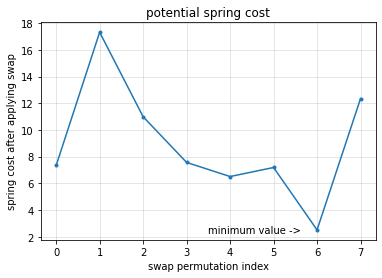

In [14]:
''' apply each swap and collect spring cost '''

# extract just the one distance matrix needed for this demo
pretend_distances = demo_BIMT._distances[1].numpy()

# try each swap
spring_cost = list()
for _swap in temp_swaps:
    spring_cost.append((pretend_weights.T[_swap].T * pretend_distances).sum())
    
# plot
plt.plot(spring_cost, marker='.')
plt.grid(alpha=0.4)
plt.ylabel('spring cost after applying swap')
plt.xlabel('swap permutation index')
plt.text(3.5,2.3,'minimum value ->')
plt.title('potential spring cost')
# get best
best_swap = temp_swaps[np.array(spring_cost).argmin()]

Now that we have the position for this neuron that minimizes the spring cost, we update the position by swapping the weights

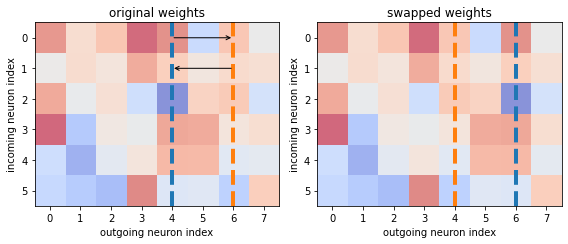

In [15]:

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(pretend_weights,cmap='coolwarm',alpha=0.6)
ax[0].axvline(4,c='tab:blue',linewidth=4,ls='--')
ax[0].axvline(6,c='tab:orange',linewidth=4,ls='--')
ax[0].set_title('original weights')
ax[0].annotate("", xy=(6, 0), xytext=(4, 0), arrowprops=dict(arrowstyle="->"))
ax[0].annotate("", xy=(4, 1), xytext=(6, 1), arrowprops=dict(arrowstyle="->"))
ax[0].set_xlabel('outgoing neuron index')
ax[0].set_ylabel('incoming neuron index')

ax[1].imshow(pretend_weights.T[best_swap].T,cmap='coolwarm',alpha=0.6)
ax[1].axvline(4,c='tab:orange',linewidth=4,ls='--')
ax[1].axvline(6,c='tab:blue',linewidth=4,ls='--')
ax[1].set_title('swapped weights')
ax[1].set_xlabel('outgoing neuron index')
ax[1].set_ylabel('incoming neuron index')
plt.tight_layout()


The above is a brief overview of the process of swapping, and not a perfect copy of what the code actually does. The subsequent weight matrix must also be adjusted, along with the bias.